In [1]:
import pyspark,datetime,ogr

In [2]:
import pandas

In [3]:
sc = pyspark.SparkContext()

In [4]:
rdd = sc.textFile("e:/110000.csv")

In [5]:
def mymap(line):
    m = line.split(",")
    return (m[1],{datetime.datetime.strptime(m[0],'%Y-%m-%d %H:%M:%S'):m})
def mymap2(x):
    m = {}
    for x1 in x[1]:
        for xk in x1:
            m[xk] = (x1[xk][2],x1[xk][3])
    startPnt = m[min(m)]
    endPnt = m[max(m)]
    return ([startPnt,endPnt])

In [6]:
gk = rdd.map(lambda line : mymap(line)).groupByKey()\
.map(lambda x : mymap2(x))

In [20]:
print(gk.count())

8028


In [8]:
def mymap3(line):
    pntline = list(line)
    pnt1 = pygeohash.encode(float(pntline[0][1]),float(pntline[0][0]),6)
    pnt2 = pygeohash.encode(float(pntline[1][1]),float(pntline[1][0]),6)
    return ("{0}_{1}".format(pnt1,pnt2),1)

In [9]:
gh = gk.map(lambda line : mymap3(line)).reduceByKey(lambda x,y : x+y)

In [10]:
res =  gh.collect()

In [11]:
len(res)

4100

In [12]:
od = pandas.DataFrame(res,columns=["geohash","count"])

In [13]:
od.sort_values("count",ascending=False).head()

,geohash,count
2075,wx4dy7_wx4dy7,48
2154,wx4g3b_wx4g3b,38
2038,wx4g4b_wx4g4b,36
139,wx4dxt_wx4dxt,32
2065,wx4gve_wx4gve,31


In [14]:
import matplotlib.pyplot as plt
import matplotlib.lines as le

In [15]:
import json,arcpy
with arcpy.da.SearchCursor("./data/bj.shp", ["SHAPE@JSON"]) as cursor:
    for r in cursor:
        bj = json.loads(r[0])["rings"][0]

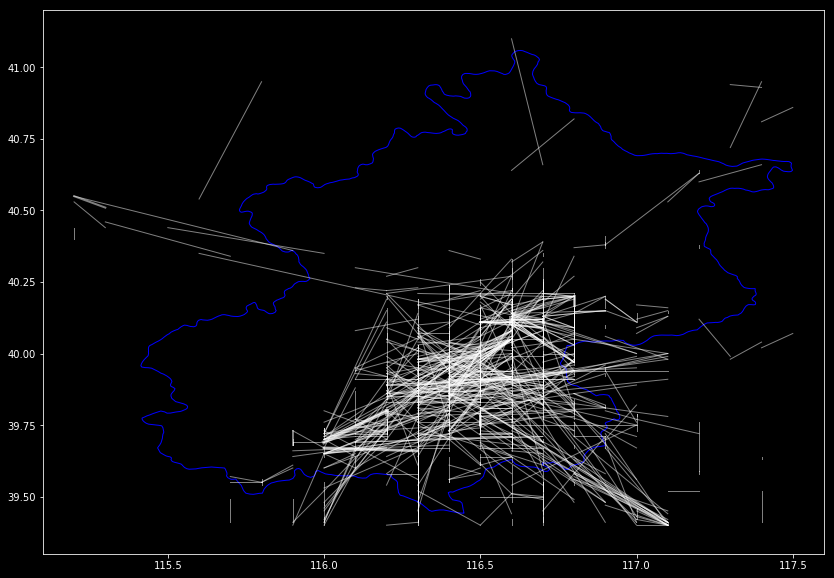

In [19]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(14,10))
ax = fig.gca()
for i in range(len(od)):
    gh = od["geohash"][i].split("_")
    if gh[0] == gh[1]:
        pass
    else:
        pt1 = pygeohash.decode(gh[0])
        pt2 = pygeohash.decode(gh[1])
        xdata = [pt1[1],pt2[1]]
        ydata = [pt1[0],pt2[0]]
        ax.add_line(le.Line2D(xdata,ydata,color='w',linewidth=od["count"][i],
                        alpha=0.5))
ax.add_patch(plt.Polygon(bj,ec="b",fc="None"))
ax.set_xlim(115.1,117.6)
ax.set_ylim(39.3,41.2)
plt.show()